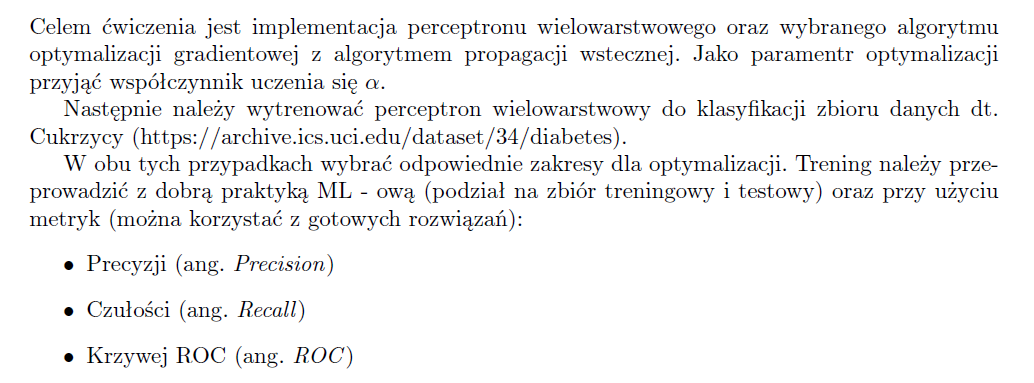

In [8]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import numpy as np

In [74]:
def prepare_data(path : str) -> tuple:
    files = glob.glob(f'{path}/data-*')
    scaler = MinMaxScaler()
    aggregated_data = pd.DataFrame()

    for file in files:
        current_data = pd.read_csv(file, delimiter='\t', header=None, names=['Date', 'Time', 'Type', 'Insulin'])
        aggregated_data = pd.concat([aggregated_data, current_data])

    aggregated_data = aggregated_data[['Date', 'Time', 'Insulin', 'Type']]

    columns_to_normalize = ['Insulin', 'Time', 'Date']
    aggregated_data['Insulin'] = aggregated_data['Insulin'].replace(["0Hi", "0Lo", "0''"], 0.0)
    aggregated_data['Time'] = pd.to_datetime(aggregated_data['Time'], format='%H:%M', errors='coerce').dt.time
    aggregated_data['Time'] = aggregated_data['Time'].apply(lambda x: x.hour * 60 + x.minute)
    aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'], format='%m-%d-%Y', errors='coerce')
    aggregated_data['Date'] = aggregated_data['Date'].dt.dayofyear
    aggregated_data = aggregated_data.dropna()

    aggregated_data[columns_to_normalize] = scaler.fit_transform(aggregated_data[columns_to_normalize])

    aggregated_data = pd.get_dummies(aggregated_data, columns=['Type'], dtype=int)

    aggregated_data.to_csv('normalized_data.csv', index=False)

    features = aggregated_data[['Date', 'Time', 'Insulin']].to_numpy()
    headers = aggregated_data.columns.values.tolist()
    labels = aggregated_data[[col for col in headers if col.startswith('Type')]].to_numpy()

    features_train, features_test, labels_train, labels_test = tts(features, labels, test_size=0.2, random_state=42)

    result = []
    for dataset in (features_train, features_test, labels_train, labels_test):
        temp = []
        for row in dataset:
            temp.append([row])
        result.append(np.array(temp))

    return tuple(result)

In [18]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [19]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [20]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [62]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [78]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [24]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [ ]:
x_train, x_test, y_train, y_test = prepare_data('/home/oliwier/WSI_lab/lab_6/Diabetes-Data')

net = Network()
net.add(FCLayer(3, 4))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FCLayer(4, 23))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train[0])
print(out)
print(y_train[0])